# Tangles on real world data
This Juypter Notebook explores the performance on Tangles on classical triplet datasets. [Examples are given in the cblearn libary.](https://github.com/dekuenstle/cblearn#datasets)

As always, we use SOE-kMeans as a baseline.

In [21]:
import sys
sys.path.append("..")
from cblearn.embedding import SOE
import cblearn.datasets as datasets
from cblearn.preprocessing import triplets_from_mostcentral
from questionnaire import Questionnaire, majority_neighbour_cuts
from baselines import Baseline
from sklearn.cluster import KMeans
from plotting import AltairPlotter
from sklearn.metrics import normalized_mutual_info_score
from estimators import OrdinalTangles
import numpy as np
import altair as alt
alt.renderers.enable('altair_saver', fmts=["html", "svg"])
seed = 3

We will take a look at the so-called car dataset (see more at the CB Learn repository).  In this dataset, users select the odd-one-out from three images of cars. Triplets (A,B,C) have been put into a form, such that the following holds:

> From the three objects A, B, C, *A* is the most central object.

The transformation from cblearn assumes that the triangle inequality holds, which might already be a problem here (this could induce bias that the Tangles algorithm doesn't play into, but SOE-kMeans does). 

In [22]:
# First we are setting up the data
cars = datasets.fetch_car_similarity()
n_clusters = len(cars.class_name.tolist())
triplets = triplets_from_mostcentral(cars.triplet, cars.response)
# respones are just set to always be one (0 would yield the same clustering result)
responses = np.ones(triplets.shape[0]).astype(bool) 
ys = cars.class_id

q = Questionnaire.from_bool_array(triplets, responses)
q_imp = q.impute("random")

# predictions
# tangles
tangles = OrdinalTangles(agreement=8)
ys_tangles = tangles.fit_predict(q_imp.values)
tangles_maj = OrdinalTangles(agreement=5)
# Experimental: doing cutoffs with a sigmoid. Turns out pretty random in this case (as expected).
# ys_tangles_maj = tangles_maj.fit_predict(majority_neighbour_cuts(triplets, radius=1.5, sigmoid_scale=3, seed=4))
ys_tangles_maj = tangles_maj.fit_predict(majority_neighbour_cuts(triplets, radius=1.8))
 
# soe-kmeans
soe = SOE(4, random_state=1)
kmeans = KMeans(4, random_state=1)
embedding = soe.fit_transform(triplets, responses)
ys_soe = kmeans.fit_predict(embedding)

# direct kMeans
ys_kmeans = kmeans.fit_predict(q_imp.values)

In [23]:
print(f"NMI SOE-kMeans: {normalized_mutual_info_score(ys, ys_soe)}")
print(f"NMI direct kMeans: {normalized_mutual_info_score(ys, ys_kmeans)}")
print(f"NMI Tangles: {normalized_mutual_info_score(ys, ys_tangles)}")
print(f"NMI Tangles Majority Cuts: {normalized_mutual_info_score(ys, ys_tangles_maj)}")
print(f"#Clusters found with Tangles: {np.unique(ys_tangles).shape[0]}")
print(f"#Clusters found with majority Tangles: {np.unique(ys_tangles_maj).shape[0]}")

NMI SOE-kMeans: 0.6950938912358169
NMI direct kMeans: 0.035017961825902055
NMI Tangles: 0.0628921854700429
NMI Tangles Majority Cuts: 0.48468782424183926
#Clusters found with Tangles: 4
#Clusters found with majority Tangles: 4


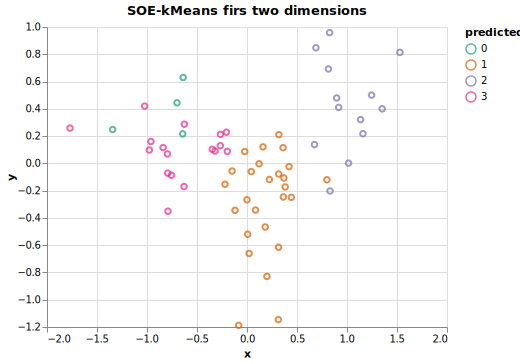

In [24]:
p = AltairPlotter()
p.assignments(embedding[:, 0:2], ys_soe).properties(title="SOE-kMeans firs two dimensions")

The problem that we are faced with Tangles, is that we do not have any suitable imputation in this case. As every entry that we get is only a 1, if we do k-NN imputation, we will end up with 1s in every part of the array. 

If we do random imputation, we will end up with bad performance (as has been observed numerous times). 

This could be a serious challenge and goes against the models we have imagined so far (Triplets as mindsets, similar objects answer similarly).

To iterate on this problem, we have investigated a new cut-finding method in the next Jupyter notebook (majority cuts). The results have also been added to this notebook, but seem to be subpar (only 0.5 of the NMI that SOE-kMeans achieves).